In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D,\
        AveragePooling2D, UpSampling2D, Activation, Flatten,\
        Reshape, merge
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.datasets import mnist, cifar10
from keras.layers.merge import Concatenate, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg19 import VGG19
from keras import metrics
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.utils import to_categorical, plot_model

from PIL import Image
import scipy.misc
from scipy.misc import imsave
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib import animation,rc
import bcolz
import math
import pydot
import graphviz
from IPython.display import HTML
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from time import time

Using TensorFlow backend.


In [2]:
(x_all, y_all), (x_test, y_test) = mnist.load_data()
x_train = x_all[:50000]
y_train = y_all[:50000]

x_validate = x_all[50000:]
y_validate = y_all[50000:]

#Normal dataset
x_train = x_train.astype('float32') / 255.
x_validate = x_validate.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, 3)
x_validate = np.expand_dims(x_validate, 3)
x_test = np.expand_dims(x_test, 3)

y_train = to_categorical(y_train, num_classes = 10)
y_validate = to_categorical(y_validate, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

x_train.shape, x_test.shape, y_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 10))

## Load Classifier Model

In [3]:
classifier = load_model('classifier_.h5') 
classifier.compile(Adam(),loss='categorical_crossentropy')

In [4]:
#Accuracy on test set
'''Test our classifier accuracy'''
prediction = classifier.predict(x_test)
c = 0.0
for i in range (len(prediction)):
    if np.argmax(prediction[i]) == np.argmax(y_test[i]):
        c += 1.0

acc = c/len((prediction))
print('Accuracy on test set: %.2f%%' % (acc * 100.0))

Accuracy on test set: 98.48%


# Generate Adversarial Examples

In [5]:
'''First, we need to calculate the gradient signs for each image'''
prediction_one_hot = np.zeros(10000)
for i in range(10000):
    prediction_one_hot[i] = np.argmax(prediction[i])
target = np.zeros((10000,10))
for i in range(10000):
    target[i] = to_categorical(prediction_one_hot[i], 10)
var = K.variable(target)
loss = metrics.categorical_crossentropy(classifier.output, var)
'''Calculate the gradient'''
gradients_ = K.gradients(loss, classifier.input)
gradients = K.function([classifier.input], gradients_)
grads = gradients([x_test])[0]
'''Get the sign of the derivative'''
gradient_signs = np.sign(grads)

In [8]:
epsilon = 0.2
adversaries = gradient_signs * epsilon
adv_imgs = x_test + adversaries
adv_imgs = np.clip(adv_imgs, 0.0, 1.0)

In [10]:
prediction.shape

(10000, 10)

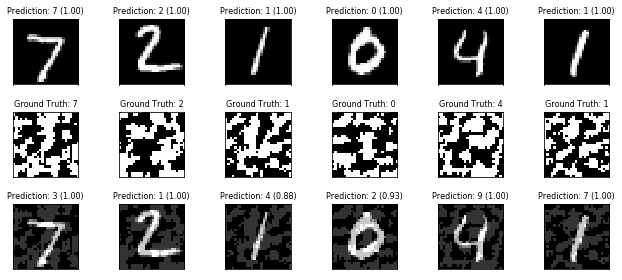

In [11]:
'''Show some adversarial images and the predictions of the classifier'''
adv_pred = classifier.predict(adv_imgs)

fig,ax = plt.subplots(nrows = 3, ncols = 6, figsize = (9,4))
for i in range(6):
    # display original images
    ax[0,i].imshow(x_test[i,:,:,0], cmap = 'gray')
    title = 'Prediction: ' + str(np.argmax(prediction[i]))\
            + ' (' +\
            '%.2f' % (np.amax(prediction[i]))\
            + ')'
    ax[0,i].set_title(title, fontsize = 8)
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display adversaries
    ax[1,i].imshow(adversaries[i,:,:,0], cmap = 'gray')
    title = 'Ground Truth: ' +\
            str(np.argmax(y_test[i]))
    ax[1,i].set_title(title, fontsize = 8)
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display adversarial images
    ax[2,i].imshow(adv_imgs[i,:,:,0], cmap = 'gray')
    title = 'Prediction: ' + str(np.argmax(adv_pred[i]))\
            + ' (' +\
            '%.2f' % (np.amax(adv_pred[i]))\
            + ')'
    ax[2,i].set_title(title, fontsize = 8)
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [13]:
'''Accuracy on adversarial test set'''
c = 0.0
for i in range (len(adv_pred)):
    if np.argmax(adv_pred[i]) == np.argmax(y_test[i]):
        c += 1.0

acc_adv = c/len((adv_pred))
print('Classifier ccuracy on adversarial test set: %.2f%%' % (acc_adv * 100.0))

Classifier ccuracy on adversarial test set: 4.98%
